In [2]:
pip install pysurvival

  Using cached pysurvival-0.1.2.tar.gz (4.7 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached progressbar-2.5-py3-none-any.whl
  Using cached sklearn-0.0.post5-py3-none-any.whl
  Running setup.py clean for pysurvival
Failed to build pysurvival
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [185 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-310
  creating build\lib.win-amd64-cpython-310\pysurvival
  copying pysurvival\__init__.py -> build\lib.win-amd64-cpython-310\pysurvival
  creating build\lib.win-amd64-cpython-310\pysurvival\datasets
  copying pysurvival\datasets\__init__.py -> build\lib.win-amd64-cpython-310\pysurvival\datasets
  creating build\lib.win-amd64-cpython-310\pysurvival\models
  copying pysurvival\models\multi_task.py -> build\lib.win-amd64-cpython-310\pysurvival\models
  copying pysurvival\models\non_parametric.py -> build\lib.win-amd64-cpython-310\pysurvival\models
  copying pysurvival\models\parametric.py -> build\lib.win-amd64-cpython-310\pysurvival\models
  copying pysurvival\models\semi_parametric.py -> build\lib.win-amd64-cpython-310\pysurvival\models
 

In [650]:
# Use DeepSurv from the repo
import sys
sys.path.append('../deepsurv')
#import deepsurv

from deepsurv.deepsurv_logger import DeepSurvLogger, TensorboardLogger
from deepsurv.deep_surv import DeepSurv

import numpy as np
import pandas as pd

import lasagne
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
import sys
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_selection import SelectKBest

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
#import scikitplot as skplt
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import statistics as st


# packages for Survival analyis
import xgboost as xgb

from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, cumulative_dynamic_auc, concordance_index_ipcw, integrated_brier_score
from sksurv.ensemble import RandomSurvivalForest, ExtraSurvivalTrees
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.kernels import clinical_kernel
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.nonparametric import kaplan_meier_estimator



<frozen importlib._bootstrap>:241: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 1160 from PyObject


## -----------------------------------------<br><br>Import data

In [2]:
df = pd.read_csv('data/RW_DATA_CUT-OFF_17.06.2021.csv')
data = df[['IT/CTIT', 'SurgeryY/N','AgeAtIO','Gender', 'SquamousNonSquamous', 'stadioAllaDiagnosi', 'fumoAllaDiagnosi','PDL1/1/149/50', 'LineaDiTerapiaICI', 'StageBasaleIO',  'BMIIoBasal', 'PS Baseline IO', 'TumorStage_IO', 'NodeStage_IO', 'MLiverBasale', 'RTPreIT', 'LeukocytesIOBasal', 'NeutrophylsiAlBasale', 'MonocytesalBasale','LymphocytesAlBasale','NLR','LDHAlBasale', 'MBoneBasale','MPleuraBasale', 'MLinfonodiBasale', 'MSurreneBasale', 'MBrainBasale','StatusOS','OSGeneraleMesi']] 

# 'MetastatisStageIO' is already excluded

data

,IT/CTIT,SurgeryY/N,AgeAtIO,Gender,SquamousNonSquamous,stadioAllaDiagnosi,fumoAllaDiagnosi,PDL1/1/149/50,LineaDiTerapiaICI,StageBasaleIO,...,LymphocytesAlBasale,NLR,LDHAlBasale,MBoneBasale,MPleuraBasale,MLinfonodiBasale,MSurreneBasale,MBrainBasale,StatusOS,OSGeneraleMesi
0,2,0,81.333333,0,1,4,3,2.0,1,2,...,1400.0,3.357143,324.0,0,0,1,1,0,0,18.900000
1,1,1,73.166667,0,1,3,2,2.0,3,2,...,1100.0,4.272727,299.0,1,1,0,0,0,1,18.700000
2,1,0,78.666667,1,1,4,2,3.0,3,1,...,1600.0,2.687500,267.0,0,0,0,0,0,1,96.000000
3,1,0,44.333333,1,1,4,0,3.0,1,1,...,1300.0,10.615385,588.0,0,1,0,0,0,1,13.833333
4,1,0,61.583333,0,2,3,2,3.0,2,1,...,1400.0,1.571429,356.0,0,0,0,0,0,0,41.733333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,1,0,63.166667,0,1,4,1,3.0,1,1,...,1900.0,2.526316,NaN,1,0,0,0,0,0,48.366667
476,2,0,69.166667,1,1,4,1,NaN,1,2,...,1200.0,4.333333,649.0,1,0,1,0,1,1,7.233333
477,1,0,74.250000,1,1,4,2,3.0,2,1,...,900.0,4.888889,398.0,0,1,0,0,0,1,10.866667
478,1,0,66.833333,0,1,4,2,3.0,1,1,...,2300.0,3.173913,325.0,1,0,0,0,0,1,6.700000


In [3]:
print(data.isna().sum())

IT/CTIT                   0
SurgeryY/N                0
AgeAtIO                   0
Gender                    0
SquamousNonSquamous       0
stadioAllaDiagnosi        0
fumoAllaDiagnosi          0
PDL1/1/149/50           116
LineaDiTerapiaICI         0
StageBasaleIO             0
BMIIoBasal               51
PS Baseline IO            0
TumorStage_IO             0
NodeStage_IO              0
MLiverBasale              0
RTPreIT                   0
LeukocytesIOBasal        26
NeutrophylsiAlBasale     25
MonocytesalBasale        29
LymphocytesAlBasale      29
NLR                      29
LDHAlBasale              88
MBoneBasale               0
MPleuraBasale             0
MLinfonodiBasale          0
MSurreneBasale            0
MBrainBasale              0
StatusOS                  0
OSGeneraleMesi            3
dtype: int64


In [4]:
data

,IT/CTIT,SurgeryY/N,AgeAtIO,Gender,SquamousNonSquamous,stadioAllaDiagnosi,fumoAllaDiagnosi,PDL1/1/149/50,LineaDiTerapiaICI,StageBasaleIO,...,LymphocytesAlBasale,NLR,LDHAlBasale,MBoneBasale,MPleuraBasale,MLinfonodiBasale,MSurreneBasale,MBrainBasale,StatusOS,OSGeneraleMesi
0,2,0,81.333333,0,1,4,3,2.0,1,2,...,1400.0,3.357143,324.0,0,0,1,1,0,0,18.900000
1,1,1,73.166667,0,1,3,2,2.0,3,2,...,1100.0,4.272727,299.0,1,1,0,0,0,1,18.700000
2,1,0,78.666667,1,1,4,2,3.0,3,1,...,1600.0,2.687500,267.0,0,0,0,0,0,1,96.000000
3,1,0,44.333333,1,1,4,0,3.0,1,1,...,1300.0,10.615385,588.0,0,1,0,0,0,1,13.833333
4,1,0,61.583333,0,2,3,2,3.0,2,1,...,1400.0,1.571429,356.0,0,0,0,0,0,0,41.733333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,1,0,63.166667,0,1,4,1,3.0,1,1,...,1900.0,2.526316,NaN,1,0,0,0,0,0,48.366667
476,2,0,69.166667,1,1,4,1,NaN,1,2,...,1200.0,4.333333,649.0,1,0,1,0,1,1,7.233333
477,1,0,74.250000,1,1,4,2,3.0,2,1,...,900.0,4.888889,398.0,0,1,0,0,0,1,10.866667
478,1,0,66.833333,0,1,4,2,3.0,1,1,...,2300.0,3.173913,325.0,1,0,0,0,0,1,6.700000


In [5]:
# there are 3 missing values of OSGenerale, I delete the corresponding records
data=data.dropna(subset=['OSGeneraleMesi'])
X_raw=data.iloc[:,:-2]
y_raw=data.iloc[:,-2:]
X_raw

,IT/CTIT,SurgeryY/N,AgeAtIO,Gender,SquamousNonSquamous,stadioAllaDiagnosi,fumoAllaDiagnosi,PDL1/1/149/50,LineaDiTerapiaICI,StageBasaleIO,...,NeutrophylsiAlBasale,MonocytesalBasale,LymphocytesAlBasale,NLR,LDHAlBasale,MBoneBasale,MPleuraBasale,MLinfonodiBasale,MSurreneBasale,MBrainBasale
0,2,0,81.333333,0,1,4,3,2.0,1,2,...,4700.0,400.0,1400.0,3.357143,324.0,0,0,1,1,0
1,1,1,73.166667,0,1,3,2,2.0,3,2,...,4700.0,400.0,1100.0,4.272727,299.0,1,1,0,0,0
2,1,0,78.666667,1,1,4,2,3.0,3,1,...,4300.0,400.0,1600.0,2.687500,267.0,0,0,0,0,0
3,1,0,44.333333,1,1,4,0,3.0,1,1,...,13800.0,1200.0,1300.0,10.615385,588.0,0,1,0,0,0
4,1,0,61.583333,0,2,3,2,3.0,2,1,...,2200.0,200.0,1400.0,1.571429,356.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,1,0,63.166667,0,1,4,1,3.0,1,1,...,4800.0,300.0,1900.0,2.526316,NaN,1,0,0,0,0
476,2,0,69.166667,1,1,4,1,NaN,1,2,...,5200.0,500.0,1200.0,4.333333,649.0,1,0,1,0,1
477,1,0,74.250000,1,1,4,2,3.0,2,1,...,4400.0,600.0,900.0,4.888889,398.0,0,1,0,0,0
478,1,0,66.833333,0,1,4,2,3.0,1,1,...,7300.0,1100.0,2300.0,3.173913,325.0,1,0,0,0,0


In [6]:
y_raw

,StatusOS,OSGeneraleMesi
0,0,18.900000
1,1,18.700000
2,1,96.000000
3,1,13.833333
4,0,41.733333
...,...,...
475,0,48.366667
476,1,7.233333
477,1,10.866667
478,1,6.700000


## ------------------------------------<br><br> Splitting & imputation

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, random_state=84, test_size = 0.1)
X_train

,IT/CTIT,SurgeryY/N,AgeAtIO,Gender,SquamousNonSquamous,stadioAllaDiagnosi,fumoAllaDiagnosi,PDL1/1/149/50,LineaDiTerapiaICI,StageBasaleIO,...,NeutrophylsiAlBasale,MonocytesalBasale,LymphocytesAlBasale,NLR,LDHAlBasale,MBoneBasale,MPleuraBasale,MLinfonodiBasale,MSurreneBasale,MBrainBasale
213,1,0,54.250000,1,2,4,1,NaN,2,1,...,2800.0,400.0,1600.0,1.750000,338.0,0,0,0,0,1
231,1,1,76.083333,1,1,2,1,3.0,2,2,...,5500.0,520.0,1100.0,5.000000,494.0,0,0,0,1,0
153,1,0,60.083333,0,1,4,2,3.0,3,2,...,2700.0,400.0,600.0,4.500000,401.0,0,1,0,0,0
167,1,0,61.500000,1,1,3,2,2.0,2,1,...,2200.0,300.0,1100.0,2.000000,381.0,0,0,0,0,0
282,1,0,62.000000,0,1,4,2,2.0,2,1,...,5300.0,400.0,1200.0,4.416667,298.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,2,0,77.666667,1,1,4,2,1.0,1,2,...,4700.0,300.0,600.0,7.833333,255.0,1,0,0,1,0
314,2,0,57.000000,0,1,3,1,1.0,1,0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
347,1,0,73.000000,1,2,4,2,2.0,1,1,...,10200.0,600.0,1500.0,6.800000,302.0,0,1,0,1,0
243,1,1,60.916667,1,2,3,2,2.0,1,2,...,4500.0,300.0,600.0,7.500000,304.0,1,1,0,1,0


In [8]:
# IMPUTATION

# define imputer
imputer = IterativeImputer()
# fit on the dataset
imputer.fit(X_train)
# transform the dataset
X1 = imputer.transform(X_train)
X2 = imputer.transform(X_test)
X_train = pd.DataFrame(X1, columns=X_train.columns)
X_test = pd.DataFrame(X2, columns=X_train.columns)

X_train['PDL1/1/149/50']=round(X_train['PDL1/1/149/50']).astype('int64')
X_test['PDL1/1/149/50']=round(X_test['PDL1/1/149/50']).astype('int64')
X_train
# This Multivariate approach assigns imputed values by solving a linear regression problem performed on other features. 
# Each feature containing missing values is, in turn, considered the target of the regression model. The
# imputation algorithm is fitted on the training set and then applied to both training and test dataset

,IT/CTIT,SurgeryY/N,AgeAtIO,Gender,SquamousNonSquamous,stadioAllaDiagnosi,fumoAllaDiagnosi,PDL1/1/149/50,LineaDiTerapiaICI,StageBasaleIO,...,NeutrophylsiAlBasale,MonocytesalBasale,LymphocytesAlBasale,NLR,LDHAlBasale,MBoneBasale,MPleuraBasale,MLinfonodiBasale,MSurreneBasale,MBrainBasale
0,1.0,0.0,54.250000,1.0,2.0,4.0,1.0,2,2.0,1.0,...,2800.000000,400.000000,1600.000000,1.750000,338.000000,0.0,0.0,0.0,0.0,1.0
1,1.0,1.0,76.083333,1.0,1.0,2.0,1.0,3,2.0,2.0,...,5500.000000,520.000000,1100.000000,5.000000,494.000000,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,60.083333,0.0,1.0,4.0,2.0,3,3.0,2.0,...,2700.000000,400.000000,600.000000,4.500000,401.000000,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,61.500000,1.0,1.0,3.0,2.0,2,2.0,1.0,...,2200.000000,300.000000,1100.000000,2.000000,381.000000,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,62.000000,0.0,1.0,4.0,2.0,2,2.0,1.0,...,5300.000000,400.000000,1200.000000,4.416667,298.000000,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,2.0,0.0,77.666667,1.0,1.0,4.0,2.0,1,1.0,2.0,...,4700.000000,300.000000,600.000000,7.833333,255.000000,1.0,0.0,0.0,1.0,0.0
425,2.0,0.0,57.000000,0.0,1.0,3.0,1.0,1,1.0,0.0,...,6120.395533,519.076655,1429.375056,5.519192,412.044433,0.0,0.0,0.0,0.0,0.0
426,1.0,0.0,73.000000,1.0,2.0,4.0,2.0,2,1.0,1.0,...,10200.000000,600.000000,1500.000000,6.800000,302.000000,0.0,1.0,0.0,1.0,0.0
427,1.0,1.0,60.916667,1.0,2.0,3.0,2.0,2,1.0,2.0,...,4500.000000,300.000000,600.000000,7.500000,304.000000,1.0,1.0,0.0,1.0,0.0


## --------------------------------<br><br>FEATURE ENGINEERING

In [9]:
X_train.dtypes

IT/CTIT                 float64
SurgeryY/N              float64
AgeAtIO                 float64
Gender                  float64
SquamousNonSquamous     float64
stadioAllaDiagnosi      float64
fumoAllaDiagnosi        float64
PDL1/1/149/50             int64
LineaDiTerapiaICI       float64
StageBasaleIO           float64
BMIIoBasal              float64
PS Baseline IO          float64
TumorStage_IO           float64
NodeStage_IO            float64
MLiverBasale            float64
RTPreIT                 float64
LeukocytesIOBasal       float64
NeutrophylsiAlBasale    float64
MonocytesalBasale       float64
LymphocytesAlBasale     float64
NLR                     float64
LDHAlBasale             float64
MBoneBasale             float64
MPleuraBasale           float64
MLinfonodiBasale        float64
MSurreneBasale          float64
MBrainBasale            float64
dtype: object

In [10]:
categorical_features_indices = np.where(X_raw.dtypes == 'int64')[0]
#result = np.where(h == 'PDL1/1/149/50')
X_train_categorical=X_train.iloc[:,categorical_features_indices].astype(int)
X_train_categorical['PDL1/1/149/50']=X_train['PDL1/1/149/50']
X_test_categorical=X_test.iloc[:,categorical_features_indices].astype(int)
X_test_categorical['PDL1/1/149/50']=X_test['PDL1/1/149/50']
X_train_categorical

,IT/CTIT,SurgeryY/N,Gender,SquamousNonSquamous,stadioAllaDiagnosi,fumoAllaDiagnosi,LineaDiTerapiaICI,StageBasaleIO,PS Baseline IO,TumorStage_IO,NodeStage_IO,MLiverBasale,RTPreIT,MBoneBasale,MPleuraBasale,MLinfonodiBasale,MSurreneBasale,MBrainBasale,PDL1/1/149/50
0,1,0,1,2,4,1,2,1,1,0,2,0,1,0,0,0,0,1,2
1,1,1,1,1,2,1,2,2,1,3,2,0,1,0,0,0,1,0,3
2,1,0,0,1,4,2,3,2,0,4,2,0,1,0,1,0,0,0,3
3,1,0,1,1,3,2,2,1,0,4,1,0,0,0,0,0,0,0,2
4,1,0,0,1,4,2,2,1,1,3,0,0,1,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,2,0,1,1,4,2,1,2,1,3,2,0,1,1,0,0,1,0,1
425,2,0,0,1,3,1,1,0,1,4,2,0,0,0,0,0,0,0,1
426,1,0,1,2,4,2,1,1,1,4,2,0,0,0,1,0,1,0,2
427,1,1,1,2,3,2,1,2,1,4,3,0,1,1,1,0,1,0,2


In [11]:
numerical_features_indices = np.where(X_raw.dtypes == 'float64')[0]
X_train_numerical=X_train.iloc[:,numerical_features_indices]
X_train_numerical=X_train_numerical.drop(['PDL1/1/149/50'],axis=1)
X_test_numerical=X_test.iloc[:,numerical_features_indices]
X_test_numerical=X_test_numerical.drop(['PDL1/1/149/50'],axis=1)
X_train_numerical

,AgeAtIO,BMIIoBasal,LeukocytesIOBasal,NeutrophylsiAlBasale,MonocytesalBasale,LymphocytesAlBasale,NLR,LDHAlBasale
0,54.250000,31.699070,5300.000000,2800.000000,400.000000,1600.000000,1.750000,338.000000
1,76.083333,22.031726,7200.000000,5500.000000,520.000000,1100.000000,5.000000,494.000000
2,60.083333,22.206331,4310.000000,2700.000000,400.000000,600.000000,4.500000,401.000000
3,61.500000,23.030045,3950.000000,2200.000000,300.000000,1100.000000,2.000000,381.000000
4,62.000000,27.915519,13100.000000,5300.000000,400.000000,1200.000000,4.416667,298.000000
...,...,...,...,...,...,...,...,...
424,77.666667,19.600000,5780.000000,4700.000000,300.000000,600.000000,7.833333,255.000000
425,57.000000,26.989619,8983.018895,6120.395533,519.076655,1429.375056,5.519192,412.044433
426,73.000000,22.800000,12700.000000,10200.000000,600.000000,1500.000000,6.800000,302.000000
427,60.916667,22.205990,5750.000000,4500.000000,300.000000,600.000000,7.500000,304.000000


array([[<Axes: title={'center': 'AgeAtIO'}>,
        <Axes: title={'center': 'BMIIoBasal'}>,
        <Axes: title={'center': 'LeukocytesIOBasal'}>,
        <Axes: title={'center': 'NeutrophylsiAlBasale'}>],
       [<Axes: title={'center': 'MonocytesalBasale'}>,
        <Axes: title={'center': 'LymphocytesAlBasale'}>,
        <Axes: title={'center': 'NLR'}>,
        <Axes: title={'center': 'LDHAlBasale'}>],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

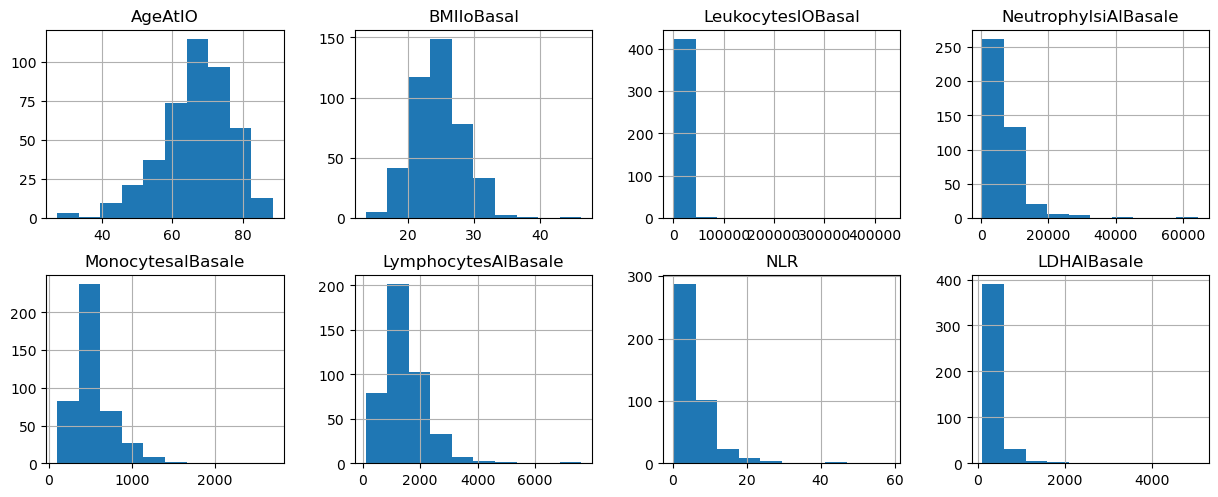

In [12]:
X=X_train_numerical


X.hist(layout=(4,4), figsize=(15,12))


In [13]:
neg_value=np.where(X['LeukocytesIOBasal']>0)[0]
X=X.iloc[neg_value,:]
print(X.shape)

(429, 8)


array([[<Axes: title={'center': 'logLeuko'}>,
        <Axes: title={'center': 'LeukocytesIOBasal'}>,
        <Axes: title={'center': 'logNLR'}>,
        <Axes: title={'center': 'NLR'}>],
       [<Axes: title={'center': 'logLDHA'}>,
        <Axes: title={'center': 'LDHAlBasale'}>, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

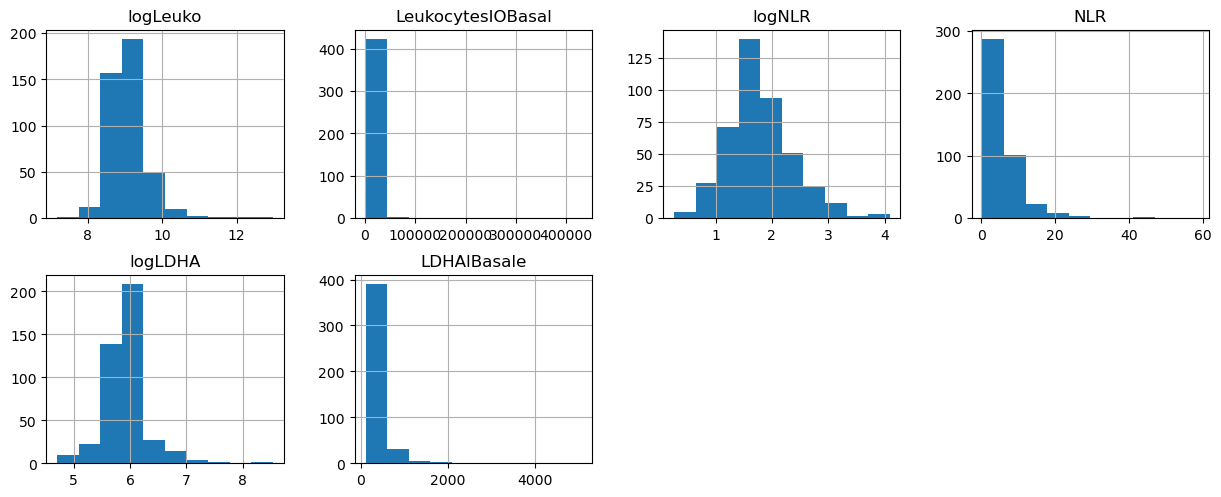

In [14]:
import math
X['logLeuko']=X['LeukocytesIOBasal'].apply(lambda x: math.log(x+1))
X['logNLR']=X['NLR'].apply(lambda x: math.log(x+1))
X['logLDHA']=X['LDHAlBasale'].apply(lambda x: math.log(x+1))

X[['logLeuko','LeukocytesIOBasal','logNLR','NLR','logLDHA','LDHAlBasale']].hist(layout=(4,4), figsize=(15,12))


In [15]:
X=X.drop(['LDHAlBasale','NLR','LeukocytesIOBasal'],axis=1)
X

,AgeAtIO,BMIIoBasal,NeutrophylsiAlBasale,MonocytesalBasale,LymphocytesAlBasale,logLeuko,logNLR,logLDHA
0,54.250000,31.699070,2800.000000,400.000000,1600.000000,8.575651,1.011601,5.826000
1,76.083333,22.031726,5500.000000,520.000000,1100.000000,8.881975,1.791759,6.204558
2,60.083333,22.206331,2700.000000,400.000000,600.000000,8.368925,1.704748,5.996452
3,61.500000,23.030045,2200.000000,300.000000,1100.000000,8.281724,1.098612,5.945421
4,62.000000,27.915519,5300.000000,400.000000,1200.000000,9.480444,1.689481,5.700444
...,...,...,...,...,...,...,...,...
424,77.666667,19.600000,4700.000000,300.000000,600.000000,8.662332,2.178532,5.545177
425,57.000000,26.989619,6120.395533,519.076655,1429.375056,9.103203,1.874750,6.023555
426,73.000000,22.800000,10200.000000,600.000000,1500.000000,9.449436,2.054124,5.713733
427,60.916667,22.205990,4500.000000,300.000000,600.000000,8.657129,2.140066,5.720312


In [16]:
h=np.array(X.index)
X_train_numerical=X
X_train_categorical=X_train_categorical.iloc[h,:]
y_train=y_train.iloc[h]

X_test_numerical['logLeuko']=X_test_numerical['LeukocytesIOBasal'].apply(lambda x: math.log(x+1))
X_test_numerical['logNLR']=X_test_numerical['NLR'].apply(lambda x: math.log(x+1))
X_test_numerical['logLDHA']=X_test_numerical['LDHAlBasale'].apply(lambda x: math.log(x+1))
X_test_numerical=X_test_numerical.drop(['NLR','LDHAlBasale','LeukocytesIOBasal'],axis=1)
X_test_numerical.columns

Index(['AgeAtIO', 'BMIIoBasal', 'NeutrophylsiAlBasale', 'MonocytesalBasale',
       'LymphocytesAlBasale', 'logLeuko', 'logNLR', 'logLDHA'],
      dtype='object')

## --------------------------<br><br> STANDARDIZATION

In [17]:
scaler = StandardScaler()
scaler.fit(X_train_numerical)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_numerical))
X_train_scaled.columns=X_train_numerical.columns
X_train_categorical.index=X_train_scaled.index

X_test_scaled = pd.DataFrame(scaler.transform(X_test_numerical))
X_test_scaled.columns=X_test_numerical.columns
X_test_categorical.index=X_test_scaled.index

In [18]:
X_train=pd.concat([X_train_scaled,X_train_categorical],axis=1)
X_test=pd.concat([X_test_scaled,X_test_categorical],axis=1)

y_train.index=X_train.index
y_test.index=X_test.index

X_train

,AgeAtIO,BMIIoBasal,NeutrophylsiAlBasale,MonocytesalBasale,LymphocytesAlBasale,logLeuko,logNLR,logLDHA,IT/CTIT,SurgeryY/N,...,TumorStage_IO,NodeStage_IO,MLiverBasale,RTPreIT,MBoneBasale,MPleuraBasale,MLinfonodiBasale,MSurreneBasale,MBrainBasale,PDL1/1/149/50
0,-1.246012,1.856246,-0.791239,-0.547583,0.192490,-0.965864,-1.353323,-0.268396,1,0,...,0,2,0,1,0,0,0,0,1,2
1,0.936869,-0.648786,-0.309190,-0.102402,-0.475270,-0.384947,0.011636,0.693996,1,1,...,3,2,0,1,0,0,0,1,0,3
2,-0.662800,-0.603542,-0.809092,-0.547583,-1.143030,-1.357900,-0.140598,0.164937,1,0,...,4,2,0,1,0,1,0,0,0,3
3,-0.521162,-0.390098,-0.898361,-0.918566,-0.475270,-1.523270,-1.201088,0.035202,1,0,...,4,1,0,0,0,0,0,0,0,2
4,-0.471173,0.875840,-0.344897,-0.547583,-0.341718,0.749996,-0.167310,-0.587594,1,0,...,3,0,0,1,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,1.095169,-1.278902,-0.452019,-0.918566,-1.143030,-0.801481,0.688330,-0.982321,2,0,...,3,2,0,1,1,0,0,1,0,1
425,-0.971069,0.635919,-0.198427,-0.105827,-0.035383,0.034591,0.156836,0.233840,2,0,...,4,2,0,0,0,0,0,0,0,1
426,0.628599,-0.449708,0.529932,0.194385,0.058938,0.691192,0.470666,-0.553809,1,0,...,4,2,0,0,0,1,0,1,0,2
427,-0.579483,-0.603630,-0.487726,-0.918566,-1.143030,-0.811347,0.621030,-0.537084,1,1,...,4,3,0,1,1,1,0,1,0,2


In [19]:
# values of the event must be boolean
y_train['StatusOS']=y_train['StatusOS'].astype(bool)
y_test['StatusOS']=y_test['StatusOS'].astype(bool)
# targets must be an array (not a dataframe)
y_tr=y_train.to_records(index=False)
y_t=y_test.to_records(index=False)

y_t

rec.array([(False,  60.93333333), (False,   5.6       ),
           ( True,  14.06666667), ( True,  52.63333333),
           ( True,   2.5       ), ( True,   1.86666667),
           ( True,  37.73333333), ( True,   8.1       ),
           ( True,  12.6       ), ( True,  37.2       ),
           ( True,  22.06666667), ( True,  22.96666667),
           (False,  50.96666667), (False,  15.16666667),
           ( True,   6.86666667), ( True,   8.26666667),
           (False,  41.63333333), ( True,  27.8       ),
           (False,  80.96666667), ( True,  10.86666667),
           ( True,  45.4       ), (False,   6.53333333),
           (False,  54.6       ), ( True,  85.        ),
           ( True,  22.06666667), (False,  54.        ),
           ( True,  21.4       ), ( True,  27.        ),
           ( True,   3.1       ), ( True,   3.1       ),
           ( True,  10.46666667), ( True, 125.13333333),
           ( True,  13.83333333), ( True,   4.96666667),
           (False,  24.6       

In [20]:
X_train.columns

Index(['AgeAtIO', 'BMIIoBasal', 'NeutrophylsiAlBasale', 'MonocytesalBasale',
       'LymphocytesAlBasale', 'logLeuko', 'logNLR', 'logLDHA', 'IT/CTIT',
       'SurgeryY/N', 'Gender', 'SquamousNonSquamous', 'stadioAllaDiagnosi',
       'fumoAllaDiagnosi', 'LineaDiTerapiaICI', 'StageBasaleIO',
       'PS Baseline IO', 'TumorStage_IO', 'NodeStage_IO', 'MLiverBasale',
       'RTPreIT', 'MBoneBasale', 'MPleuraBasale', 'MLinfonodiBasale',
       'MSurreneBasale', 'MBrainBasale', 'PDL1/1/149/50'],
      dtype='object')

## ------------------------------- <br><br>FEATURE SELECTION

### <br><br>LASSO Elastic Net

In [21]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(10, 8))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

In [22]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(X_train, y_tr)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9)

In [23]:
c=np.where(cox_elastic_net.coef_[0]==0)
c

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65],
       dtype=int64),)

In [24]:
yy=y_train.iloc[:,np.where[]]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3229491330.py, line 1)

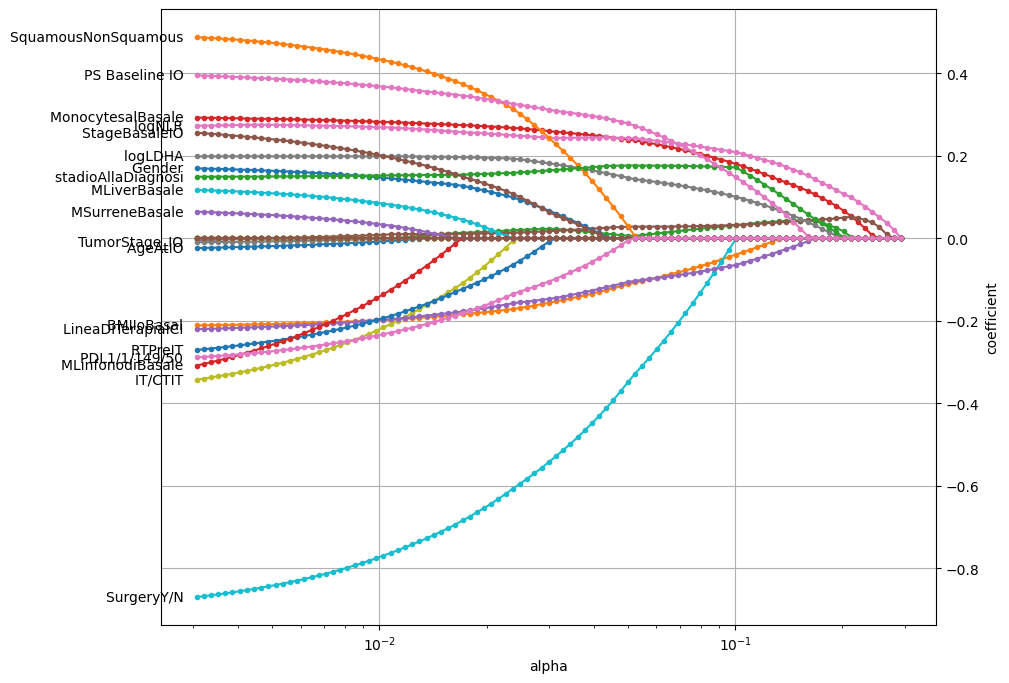

In [25]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_,
    index=X_train.columns,
    columns=np.round(cox_elastic_net.alphas_, 19)
)

plot_coefficients(coefficients_elastic_net,19)

In [26]:
estimated_alphas=cox_elastic_net.alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)

gcv = GridSearchCV(
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01),
    param_grid={"alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1)

gcv=gcv.fit(X_train,y_tr)


cv_results = pd.DataFrame(gcv.cv_results_)

C:\Users\feder\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\feder\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\feder\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)


In [27]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alphas,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011577,0.006417,0.012469,0.003343,[0.29220911279162287],{'alphas': [0.29220911279162287]},0.500000,0.500000,0.580772,0.661988,0.612661,0.571084,0.063548,99
1,0.008206,0.000101,0.008326,0.000210,[0.2789277576377674],{'alphas': [0.2789277576377674]},0.656699,0.500000,0.577015,0.660850,0.626422,0.604197,0.060093,98
2,0.008319,0.005102,0.006426,0.003213,[0.266250060573277],{'alphas': [0.266250060573277]},0.656699,0.661378,0.578552,0.660470,0.637064,0.638833,0.031409,97
3,0.004875,0.003984,0.006493,0.003247,[0.2541485844063414],{'alphas': [0.2541485844063414]},0.671901,0.661378,0.581967,0.654021,0.641468,0.642147,0.031680,96
4,0.004801,0.003920,0.003197,0.003915,[0.24259713900786306],{'alphas': [0.24259713900786306]},0.676579,0.661378,0.584358,0.653642,0.640367,0.643265,0.031699,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.008189,0.000164,0.005054,0.004151,[0.003687260802707264],{'alphas': [0.003687260802707264]},0.732376,0.792643,0.707650,0.736343,0.731009,0.740004,0.028179,39
95,0.008007,0.000016,0.006388,0.003194,[0.003519669108533894],{'alphas': [0.003519669108533894]},0.732041,0.792643,0.707650,0.735584,0.731743,0.739932,0.028174,42
96,0.006398,0.003199,0.006406,0.003203,[0.003359694715511362],{'alphas': [0.003359694715511362]},0.731039,0.792643,0.706967,0.735584,0.731743,0.739595,0.028389,50
97,0.006646,0.003327,0.006704,0.003369,[0.0032069914055462903],{'alphas': [0.0032069914055462903]},0.731373,0.792643,0.707309,0.735205,0.732110,0.739728,0.028282,48


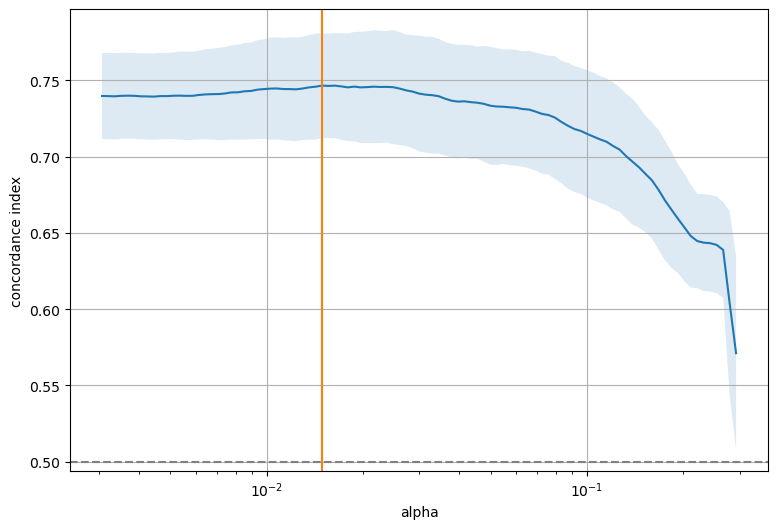

In [28]:
alphas = cv_results.param_alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [29]:
gcv.best_params_["alphas"][0]

0.014885535497475778

Number of non-zero coefficients: 19


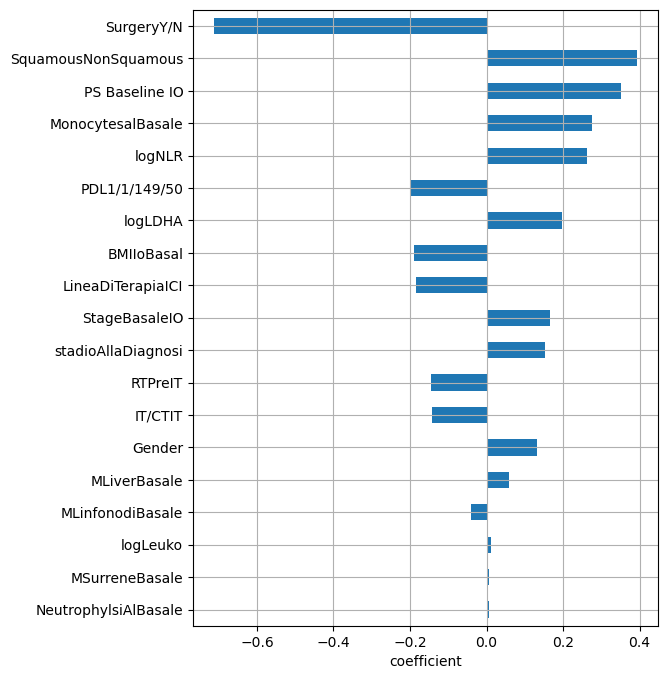

In [30]:
best_model = gcv.best_estimator_
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=X_train.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [31]:
coefs_best=best_coefs.index[np.where(best_coefs['coefficient']!=0)[0]]
coefs_best


Index(['BMIIoBasal', 'NeutrophylsiAlBasale', 'MonocytesalBasale', 'logLeuko',
       'logNLR', 'logLDHA', 'IT/CTIT', 'SurgeryY/N', 'Gender',
       'SquamousNonSquamous', 'stadioAllaDiagnosi', 'LineaDiTerapiaICI',
       'StageBasaleIO', 'PS Baseline IO', 'MLiverBasale', 'RTPreIT',
       'MLinfonodiBasale', 'MSurreneBasale', 'PDL1/1/149/50'],
      dtype='object')

In [32]:
X_tr=X_train.loc[:,coefs_best]
X_t=X_test.loc[:,coefs_best]

In [33]:
#X_tr.to_csv("data/X_train_surv.csv")
#X_t.to_csv("data/X_test_surv.csv")

#y_train.to_csv("data/y_train_surv.csv")
#y_test.to_csv("data/y_test_surv.csv")

## ---------------------------------<br><br> SURVIVAL ANALYSIS

In [34]:
#
times = np.linspace(min(y_t["OSGeneraleMesi"])+0.001,max(y_t["OSGeneraleMesi"])-0.001,30)

### <br><br> CPH model

In [35]:
cox=CoxPHSurvivalAnalysis()

In [36]:
param_grid = {'n_iter': [5,10,15,20,50,100]}
cv = KFold(n_splits=10, random_state=84, shuffle=True)
#cv=StratifiedKFold(10)
gcv = GridSearchCV(cox, param_grid, return_train_score=True, cv=cv)
gcv.fit(X_tr, y_tr)

print("Best score: {f}".format(f=gcv.best_score_))
print("Parameters: {f}".format(f=gcv.best_params_))


# con logaritmo ho migliorato il c-index

C:\Users\feder\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: ConvergenceWarning: Optimization did not converge: Maximum number of iterations has been exceeded.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\feder\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: ConvergenceWarning: Optimization did not converge: Maximum number of iterations has been exceeded.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\feder\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: ConvergenceWarning: Optimization did not converge: Maximum number of iterations has been exceeded.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\feder\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: ConvergenceWarning: Optimization did not converge: Maximum number of iterations has been exceeded.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\feder\anaconda3\lib\site-packages\sklearn\model_selecti

Best score: 0.7582583622567854
Parameters: {'n_iter': 5}


C:\Users\feder\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:910: ConvergenceWarning: Optimization did not converge: Maximum number of iterations has been exceeded.
  self.best_estimator_.fit(X, y, **fit_params)


In [37]:
cox=gcv.best_estimator_
ci_cox_train = concordance_index_censored(y_tr["StatusOS"], y_tr["OSGeneraleMesi"], cox.predict(X_tr))
ci_cox_test = concordance_index_censored(y_t["StatusOS"], y_t["OSGeneraleMesi"], cox.predict(X_t))

print("COX PROPORTIONAL HAZARDS\n----------------------")
print("C-index TRAIN: {f}".format(f=ci_cox_train[0]))
print("C-index TEST: {f}".format(f=ci_cox_test[0]))

survs_cox=cox.predict_survival_function(X_t)
preds_cox = np.asarray([[fn(t) for t in times] for fn in survs_cox])

bs_cox=integrated_brier_score(y_tr,y_t,preds_cox,times)
print("Brier Score CPH: ",bs_cox)


COX PROPORTIONAL HAZARDS
----------------------
C-index TRAIN: 0.7670456148269345
C-index TEST: 0.7841269841269841
Brier Score CPH:  0.10754714895992634


### <br><br> Random Survival Forest

In [36]:
rsf = RandomSurvivalForest()
param_grid = {'n_estimators': [200,400],
              'max_depth':[3,5],
              'min_samples_split':[6,8],
              'min_samples_leaf':[7,10]
             }

gcv1 = GridSearchCV(rsf, param_grid, return_train_score=True, cv=cv, verbose=1)
gcv1.fit(X_tr, y_tr)
print("Best score: {f}".format(f=gcv1.best_score_))
print("Parameters: {f}".format(f=gcv1.best_params_))

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best score: 0.7315114658193125
Parameters: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 8, 'n_estimators': 400}


In [37]:
rsf=gcv1.best_estimator_
ci_rsf_train = concordance_index_censored(y_tr["StatusOS"], y_tr["OSGeneraleMesi"], rsf.predict(X_tr))
# rsf.predict----> calcolo risk score
ci_rsf_test = concordance_index_censored(y_t["StatusOS"], y_t["OSGeneraleMesi"], rsf.predict(X_t))

print("RANDOM SURVIVAL FOREST\n----------------------")
print("C-index TRAIN: {c}".format(c=ci_rsf_train[0]))
print("C-index TEST: {c}".format(c=ci_rsf_test[0]))

survs_rsf=rsf.predict_survival_function(X_t)
preds_rsf = np.asarray([[fn(t) for t in times] for fn in survs_rsf])

bs_rsf=integrated_brier_score(y_tr,y_t,preds_rsf,times)
print("Brier Score RSF: ",bs_rsf)

RANDOM SURVIVAL FOREST
----------------------
C-index TRAIN: 0.7801207368331969
C-index TEST: 0.7544973544973544
Brier Score RSF:  0.12217889719674632


### <br><br> Gradient Boosting

In [41]:
# criterion='friedman_mse'---> the best criterion (di default)
# loss='coxph' ---> migliore e di default
gb = GradientBoostingSurvivalAnalysis()

param_grid={'n_estimators':[200,400],
           'learning_rate':[0.1,1],
           'min_samples_split':[5,7],
           'min_samples_leaf':[10,15],
           'max_depth':[4,6],
           }


gcv2 = GridSearchCV(gb, param_grid, return_train_score=True, cv=cv, verbose=30, n_jobs=-1)
gcv2.fit(X_tr, y_tr)
print("Best score: {f}".format(f=gcv2.best_score_))
print("Parameters: {f}".format(f=gcv2.best_params_))

Fitting 10 folds for each of 32 candidates, totalling 320 fits
Best score: 0.729014320528736
Parameters: {'learning_rate': 1, 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 7, 'n_estimators': 400}


In [42]:
gb=gcv2.best_estimator_
ci_gb_train = concordance_index_censored(y_tr["StatusOS"], y_tr["OSGeneraleMesi"], gb.predict(X_tr))
ci_gb_test = concordance_index_censored(y_t["StatusOS"], y_t["OSGeneraleMesi"], gb.predict(X_t))

print("GRADIENT BOOSTING\n----------------------")
print("C-index TRAIN: {f}".format(f=ci_gb_train[0]))
print("C-index TEST: {f}".format(f=ci_gb_test[0]))

survs_gb=gb.predict_survival_function(X_t)
preds_gb = np.asarray([[fn(t) for t in times] for fn in survs_gb])

bs_gb=integrated_brier_score(y_tr,y_t,preds_gb,times)
print("Brier Score GB: ",bs_gb)


GRADIENT BOOSTING
----------------------
C-index TRAIN: 0.9995768568930012
C-index TEST: 0.7523809523809524
Brier Score GB:  0.1665826545709146


### <br><br> FastKernelSurvival SVM

In [31]:
fks=FastKernelSurvivalSVM()
param_grid={"kernel":['linear','rbf','polinomial'], "alpha":[0.1,1,10],"gamma":[1,2], "degree":[2,3,4]}

gcv3 = GridSearchCV(fks, param_grid, return_train_score=True, cv=cv, verbose=1, n_jobs=-1)
gcv3.fit(X_tr, y_tr)
print("Best score: {f}".format(f=gcv3.best_score_))
print("Parameters: {f}".format(f=gcv3.best_params_))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best score: 0.7577589195661731
Parameters: {'alpha': 10, 'degree': 2, 'gamma': 1, 'kernel': 'linear'}


In [32]:
fks=gcv3.best_estimator_
ci_fks_train = concordance_index_censored(y_tr["StatusOS"], y_tr["OSGeneraleMesi"], fks.predict(X_tr))
ci_fks_test = concordance_index_censored(y_t["StatusOS"], y_t["OSGeneraleMesi"], fks.predict(X_t))

print("FAST KERNEL SSVM\n----------------------")
print("C-index TRAIN: {f}".format(f=ci_fks_train[0]))
print("C-index TEST: {f}".format(f=ci_fks_test[0]))

# SSVM non ha predict survival function (GB, CPH e RSF invece sì)

FAST KERNEL SSVM
----------------------
C-index TRAIN: 0.7788372027419673
C-index TEST: 0.7798941798941799


### <br><br> ExtraTree

In [45]:
et = ExtraSurvivalTrees()
param_grid = {'n_estimators': [200,400],
              'max_depth':[3,5],
              'min_samples_split':[6,8],
              'min_samples_leaf':[7,10]
             }

gcv4 = GridSearchCV(et, param_grid, return_train_score=True, cv=cv)
gcv4.fit(X_tr, y_tr)
print("Best score: {f}".format(f=gcv4.best_score_))
print("Parameters: {f}".format(f=gcv4.best_params_))

Best score: 0.7441271289536385
Parameters: {'max_depth': 3, 'min_samples_leaf': 7, 'min_samples_split': 8, 'n_estimators': 200}


In [46]:
et=gcv4.best_estimator_
ci_et_train = concordance_index_censored(y_tr["StatusOS"], y_tr["OSGeneraleMesi"], et.predict(X_tr))
ci_et_test = concordance_index_censored(y_t["StatusOS"], y_t["OSGeneraleMesi"], et.predict(X_t))

print("EXTRA TREES\n----------------------")
print("C-index TRAIN: {f}".format(f=ci_et_train[0]))
print("C-index TEST: {f}".format(f=ci_et_test[0]))

survs_et=et.predict_survival_function(X_t)
preds_et = np.asarray([[fn(t) for t in times] for fn in survs_et])

bs_et=integrated_brier_score(y_tr,y_t,preds_et,times)
print("Brier Score ET: ",bs_et)

EXTRA TREES
----------------------
C-index TRAIN: 0.7554373889249344
C-index TEST: 0.744973544973545
Brier Score ET:  0.12446881004482045


## <br><br> XGBoost (1)

In [39]:
def plot_ci(mean, upper_ci, lower_ci, i=42, title='Probability of survival $P(T \geq t)$'):
    
    # plotting mean and confidence intervals
    plt.figure(figsize=(12, 4), dpi=120)
    plt.plot(mean.columns,mean.iloc[i])
    plt.fill_between(mean.columns, lower_ci.iloc[i], upper_ci.iloc[i], alpha=0.2)

    plt.title(title)
    plt.xlabel('Time [days]')
    plt.ylabel('Probability')
    plt.tight_layout()

In [37]:
from xgbse.metrics import concordance_index, approx_brier_score
from xgbse.non_parametric import get_time_bins
from xgbse import (
    XGBSEKaplanNeighbors,
    XGBSEKaplanTree,
    XGBSEDebiasedBCE,
    XGBSEBootstrapEstimator
)
from xgbse.converters import (
    convert_data_to_xgb_format,
    convert_to_structured
)

In [124]:
dtrain = convert_data_to_xgb_format(X_tr, y_tr, 'survival:cox')
dtest = convert_data_to_xgb_format(X_t, y_t, 'survival:cox')

In [85]:
PARAMS_XGB_COX = {
    'objective': 'survival:cox',
    'tree_method': 'hist', 
    'learning_rate': 0.7, 
    'max_depth': 12, 
    'booster':'dart',
    'subsample':0.5,
    'min_child_weight': 10, 
    'colsample_bynode':0.3
}

In [174]:
bst = xgb.train(
    PARAMS_XGB_COX,
    dtrain,
    #num_boost_round=1000,
    #early_stopping_rounds=10,
    evals=[(dtrain, 'train')],
    verbose_eval=0
)

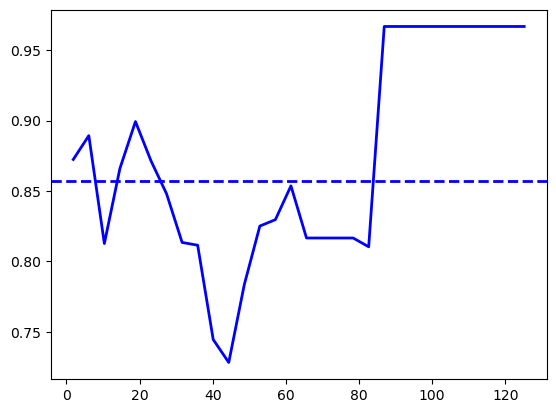

In [175]:
y_pred_xgb=bst.predict(dtest)
xgb_auc, xgb_mean_auc = cumulative_dynamic_auc(
    y_tr, y_t, y_pred_xgb, times
)


plt.plot(times, xgb_auc, "b-",label="XGB", linewidth=2)
plt.axhline(xgb_mean_auc, linestyle="--", color="b",linewidth=2)

In [176]:
ci_xgb_train = concordance_index_censored(y_tr["StatusOS"], y_tr["OSGeneraleMesi"], bst.predict(dtrain))
ci_xgb_test = concordance_index_censored(y_t["StatusOS"], y_t["OSGeneraleMesi"], bst.predict(dtest))

print("EXTREME GRADIENT BOOSTING\n----------------------")
print("C-index TRAIN: {f}".format(f=ci_xgb_train[0]))
print("C-index TEST: {f}".format(f=ci_xgb_test[0]))

#survs_xgb=bst.predict_survival_function(X_t)
#preds_xgb = np.asarray([[fn(t) for t in times] for fn in survs_xgb])

#bs_xgb=integrated_brier_score(y_tr,y_t,preds_xgb,times)
#print("Brier Score GB: ",bs_xgb)

EXTREME GRADIENT BOOSTING
----------------------
C-index TRAIN: 0.7993455386611752
C-index TEST: 0.7481481481481481


## <br><br> XGBoost (2)

C-index train: 0.7365394926207072
C-index CV: 0.7210442253522225
C-index test: 0.7372881355932204
---------------------------------------
Brier Score train: 0.11540606319123635
Brier Score CV: 0.1290296070633707
Brier Score test: 0.1182866837489751


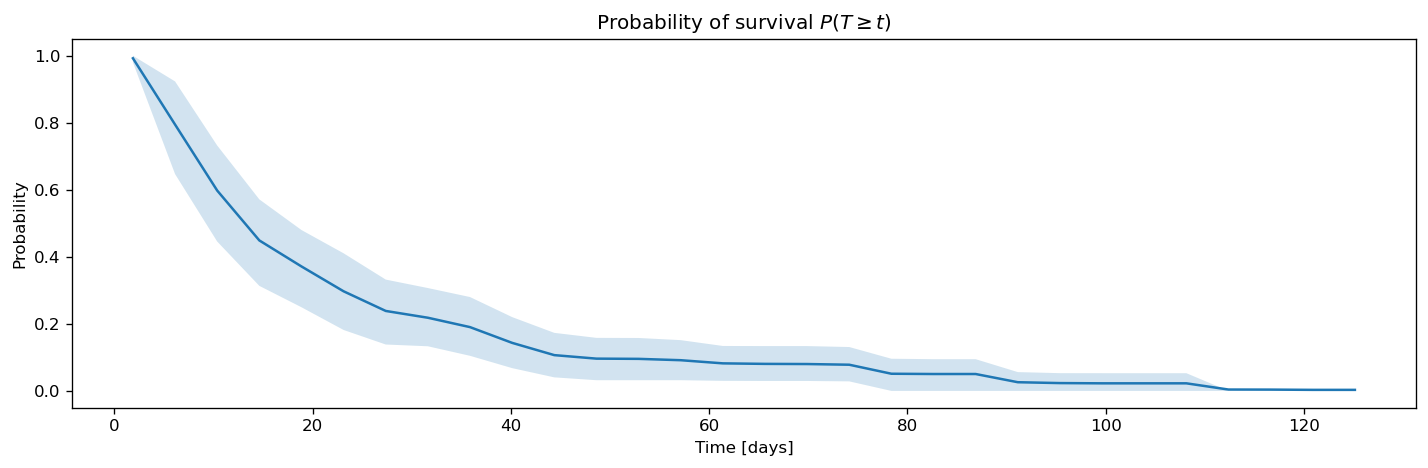

In [69]:
PARAMS_TREE = {
    'objective': 'survival:aft',
    'eval_metric': 'cox-nloglik',
    'tree_method': 'hist', 
    'max_depth': 12, 
    'booster':'dart', 
    'subsample': 1,
    'min_child_weight': 50, 
    'colsample_bynode': 1,
    'learning_rate': 1e-4
}

# base model as XGBSEKaplanTree
base_model = XGBSEKaplanTree(PARAMS_TREE)

# bootstrap meta estimator
bootstrap_estimator = XGBSEBootstrapEstimator(base_model, n_estimators=600)

# fitting the meta estimator
bootstrap_estimator.fit(X_tr, y_tr, time_bins=times)

# predicting
mean_tr, upper_ci_tr, lower_ci_tr = bootstrap_estimator.predict(X_tr, return_ci=True)
mean_t, upper_ci_t, lower_ci_t = bootstrap_estimator.predict(X_t, return_ci=True)

# print metrics
print(f"C-index train: {concordance_index(y_tr, mean_tr)}")
cind_cv = cross_val_score(bootstrap_estimator, X_tr, y_tr, scoring=make_scorer(concordance_index), cv=10)
print("C-index CV: {f}".format(f=st.mean(cind_cv)))
print(f"C-index test: {concordance_index(y_t, mean_t)}")
print("---------------------------------------")
print(f"Brier Score train: {approx_brier_score(y_tr, mean_tr)}")
brier_cv = cross_val_score(bootstrap_estimator, X_tr, y_tr, scoring=make_scorer(approx_brier_score), cv=10)
print("Brier Score CV: {f}".format(f=st.mean(brier_cv)))
print(f"Brier Score test: {approx_brier_score(y_t, mean_t)}")

# plotting CIs
plot_ci(mean_t, upper_ci_t, lower_ci_t)

In [70]:
xgb_risk_scores = 1 - mean_t.mean(axis=1)

Average XGB:  0.8458975281509324


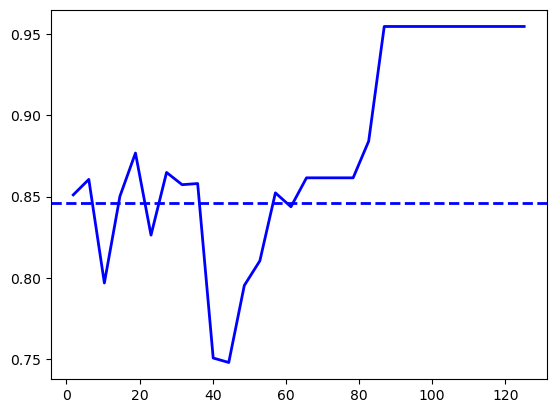

In [71]:
xgb_auc, xgb_mean_auc = cumulative_dynamic_auc(
    y_tr, y_t, xgb_risk_scores, times
)

print("Average XGB: ", xgb_mean_auc)
plt.plot(times, xgb_auc, "b-",label="XGB", linewidth=2)
plt.axhline(xgb_mean_auc, linestyle="--", color="b",linewidth=2)

## <br><br> DeepSurv(1)

In [73]:
train_df=pd.concat([X_tr, y_train], axis=1)

In [74]:

# event_col is the header in the df that represents the 'Event / Status' indicator
# time_col is the header in the df that represents the event time
event_col='StatusOS'
time_col='OSGeneraleMesi'


def dataframe_to_deepsurv_ds(df, event_col, time_col):
    # Extract the event and time columns as numpy arrays
    e = df[event_col].values.astype(np.int32)
    t = df[time_col].values.astype(np.float32)

    # Extract the patient's covariates as a numpy array
    x_df = df.drop([event_col, time_col], axis = 1)
    x = x_df.values.astype(np.float32)
    
    # Return the deep surv dataframe
    return {
        'x' : x,
        'e' : e,
        't' : t
    }

# If the headers of the csv change, you can replace the values of 
# 'event_col' and 'time_col' with the names of the new headers
# You can also use this function on your training dataset, validation dataset, and testing dataset
train_data = dataframe_to_deepsurv_ds(train_df, event_col, time_col)

In [75]:
hyperparams = {
    'L2_reg': 10.0,
    'batch_norm': True,
    'dropout': 0.4,
    'hidden_layers_sizes': [25, 25],
    'learning_rate': 1e-05,
    'lr_decay': 0.001,
    'momentum': 0.9,
    'n_in': train_data['x'].shape[1],
    'standardize': True
}

In [76]:
# Create an instance of DeepSurv using the hyperparams defined above
model = DeepSurv(**hyperparams)

# DeepSurv can now leverage TensorBoard to monitor training and validation
# This section of code is optional. If you don't want to use the tensorboard logger
# Uncomment the below line, and comment out the other three lines: 
logger = None

#experiment_name = 'test_experiment_sebastian'
#logdir = './logs/tensorboard/'
#logger = TensorboardLogger(experiment_name, logdir=logdir)

# Now we train the model
update_fn=lasagne.updates.nesterov_momentum # The type of optimizer to use. \
                                            # Check out http://lasagne.readthedocs.io/en/latest/modules/updates.html \
                                            # for other optimizers to use
n_epochs = 500

# If you have validation data, you can add it as the second parameter to the function
metrics = model.train(train_data, n_epochs=n_epochs, update_fn=update_fn)

[INFO] Training CoxMLP
Finished Training with 500 iterations in 2505.20s


In [81]:
print('Train C-Index:', metrics['train_ci'][-1])

Train C-Index: 0.7202600919631019


## DeepSurv(2)

In [49]:
import pycox
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

In [50]:
np.random.seed(123)
_ = torch.manual_seed(123)

In [51]:
x_tr=np.array(X_tr).astype('float32')
x_t=np.array(X_t).astype('float32')
x_tr

array([[ 1.8562456 , -0.7912386 , -0.5475825 , ...,  0.        ,
         0.        ,  2.        ],
       [-0.6487857 , -0.30918983, -0.10240202, ...,  0.        ,
         1.        ,  3.        ],
       [-0.6035415 , -0.8090922 , -0.5475825 , ...,  0.        ,
         0.        ,  3.        ],
       ...,
       [-0.44970813,  0.5299321 ,  0.19438496, ...,  0.        ,
         1.        ,  2.        ],
       [-0.6036298 , -0.48772642, -0.9185662 , ...,  0.        ,
         1.        ,  2.        ],
       [-0.14712338,  0.34068328,  0.15728658, ...,  0.        ,
         0.        ,  3.        ]], dtype=float32)

In [52]:
get_target = lambda df: (df['OSGeneraleMesi'].values, df['StatusOS'].values)
Y_tr=get_target(y_train)
#Y_t=get_target(y_test)
#Y_tr

In [53]:
in_features = x_tr.shape[1]
num_nodes = [32,32]
out_features = 1
batch_norm = True
dropout = 0.2
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [54]:
# INPUT DEVONO ESSERE DEGLI ARRAY
batch_size = 16#X_tr.shape[0]
def declare_model(mod):
    new_mod=mod
    #del mod
    #model = CoxPH(net, tt.optim.Adam)
    lrfinder = new_mod.lr_finder(x_tr, Y_tr, batch_size, tolerance=10)
    #_ = lrfinder.plot()  ---> PLOTTA ANDAMENTO
    best_lr=lrfinder.get_best_lr()
    #best_lr
    new_mod.optimizer.set_lr(1e-4)
    
    return new_mod

In [55]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
#verbose = True

In [56]:
def flatten(l):
    return [item for sublist in l for item in sublist]

#  ---------------------- CROSS-VALIDATION --------------------------
def cross_validation_deepsurv(X, y, n_folds):
    X_train_cv=[]
    y_train_cv=[]
    step=round(X.shape[0]/n_folds)
    scores=[]
    for i in range(n_folds):
        if(step*(i+1)>X.shape[0]):
            X_cv=X[step*i:X.shape[0]+1,:]
            y_cv=y[step*i:X.shape[0]+1]
        else:
            X_cv=X[step*i:step*(i+1),:]
            y_cv=y[step*i:step*(i+1)]
        X_train_cv.append(X_cv)
        y_train_cv.append(y_cv)

    for i in range(n_folds):
        mod=declare_model(CoxPH(net, tt.optim.Adam))
        X_cv_tr=X_train_cv.copy()
        X_cv_t=X_cv_tr[n_folds-1-i]
        X_cv_tr.pop(n_folds-1-i)

        y_cv_tr=y_train_cv.copy()
        y_cv_t=y_cv_tr[n_folds-1-i]
        y_cv_tr.pop(n_folds-1-i)

        y_CV_tr=get_target(pd.concat([t for t in y_cv_tr],axis=0))
        X_CV_tr=np.array(flatten(X_cv_tr))
        mod.fit(X_CV_tr, y_CV_tr, batch_size, epochs,  verbose=False)
        _ = mod.compute_baseline_hazards()
        surv_train = mod.predict_surv_df(X_cv_t)

        durations, events = get_target(y_cv_t)
        time_grid = np.linspace(durations.min(), durations.max(), 100)

        ev = EvalSurv(surv_train, durations, events, censor_surv='km')
        cind=ev.concordance_td()
        scores.append(cind)
        print("{j} fits completed".format(j=i+1))

    return scores

        


In [57]:
scores=cross_validation_deepsurv(x_tr,y_train,2)

C:\Users\feder\anaconda3\lib\site-packages\pycox\evaluation\eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


1 fits completed
2 fits completed


C:\Users\feder\anaconda3\lib\site-packages\pycox\evaluation\eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


In [58]:
model=declare_model(CoxPH(net, tt.optim.Adam))
log=model.fit(x_tr, Y_tr, batch_size, epochs,  verbose=False)
                #val_data=val, val_batch_size=batch_size)

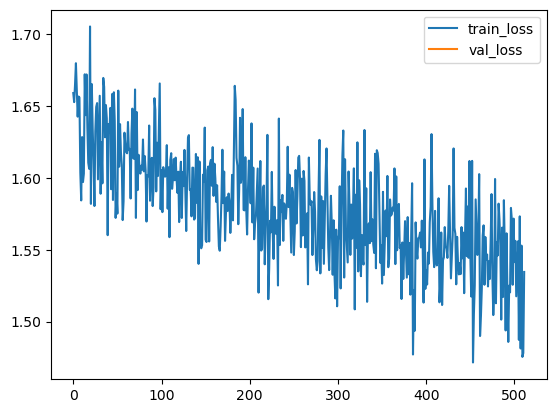

In [59]:
_ = log.plot()

In [60]:
_ = model.compute_baseline_hazards()
surv_df_test = model.predict_surv_df(x_t)
surv_df_train = model.predict_surv_df(x_tr)

In [61]:
surv_df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
duration,,,,,,,,,,,,,,,,,,,,,
0.900000,0.999491,0.988120,0.998010,0.999713,0.995997,0.997236,0.999582,0.999450,0.999004,0.999896,...,0.999874,0.995427,0.999879,0.997979,0.995326,0.996494,0.999749,0.999297,0.999723,0.993103
1.666667,0.998924,0.975071,0.995801,0.999393,0.991564,0.994170,0.999116,0.998838,0.997897,0.999780,...,0.999735,0.990365,0.999744,0.995736,0.990152,0.992609,0.999470,0.998516,0.999416,0.985488
1.933333,0.998335,0.961684,0.993509,0.999061,0.986974,0.990992,0.998633,0.998203,0.996747,0.999660,...,0.999589,0.985128,0.999604,0.993409,0.984800,0.988585,0.999180,0.997705,0.999096,0.977631
2.066667,0.997742,0.948362,0.991201,0.998726,0.982365,0.987795,0.998145,0.997562,0.995589,0.999539,...,0.999443,0.979872,0.999462,0.991066,0.979429,0.984541,0.998888,0.996886,0.998774,0.969766
2.133333,0.997145,0.935157,0.988887,0.998389,0.977753,0.984592,0.997655,0.996918,0.994425,0.999417,...,0.999295,0.974617,0.999320,0.988716,0.974060,0.980492,0.998594,0.996064,0.998450,0.961923


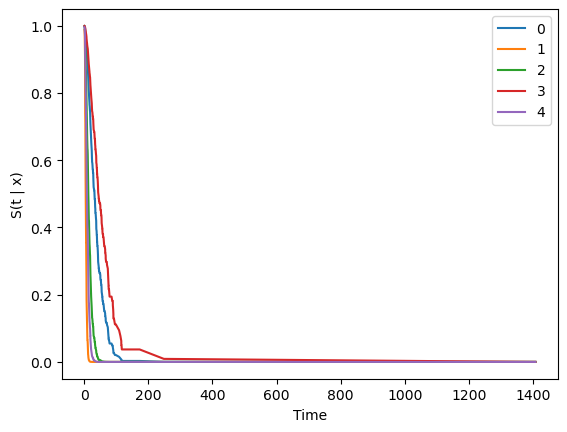

In [62]:
surv_df_test.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [ ]:
durations_test, events_test = get_target(y_test)
durations_train, events_train = get_target(y_train)
time_grid_test = np.linspace(durations_test.min(), durations_test.max(), 100)
time_grid_tr = np.linspace(durations_train.min(), durations_train.max(), 100)

In [64]:
ev_test = EvalSurv(surv_df_test, durations_test, events_test, censor_surv='km')
ev_train = EvalSurv(surv_df_train, durations_train, events_train, censor_surv='km')

C:\Users\feder\anaconda3\lib\site-packages\pycox\evaluation\eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
C:\Users\feder\anaconda3\lib\site-packages\pycox\evaluation\eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


In [65]:
print("C-index train: ",ev_train.concordance_td())
print("C-index CV: ",st.mean(scores))
print("C-index test:", ev_test.concordance_td())

C-index train:  0.8322485207100592
C-index CV:  0.7441252567239165
C-index test: 0.7463157894736843


In [66]:
print("Brier Score train: ", ev_train.integrated_brier_score(time_grid_tr))
print("Brier Score test : ", ev_test.integrated_brier_score(time_grid_test))

Brier Score train:  0.018648878433728498
Brier Score test :  0.11917417123082215


In [742]:
'''def _is_concordant(s_i, s_j, t_i, t_j, d_i, d_j):
    conc = 0.
    if t_i < t_j:
        conc = (s_i < s_j) + (s_i == s_j) * 0.5
    elif t_i == t_j: 
        if d_i & d_j:
            conc = 1. - (s_i != s_j) * 0.5
        elif d_i:
            conc = (s_i < s_j) + (s_i == s_j) * 0.5  # different from RSF paper.
        elif d_j:
            conc = (s_i > s_j) + (s_i == s_j) * 0.5  # different from RSF paper.à
    return conc * _is_comparable(t_i, t_j, d_i, d_j)
            
            
def _is_comparable(t_i, t_j, d_i, d_j):
    return ((t_i < t_j) & d_i) | ((t_i == t_j) & (d_i | d_j))

def _sum_concordant(s, t, d):
    n = len(t)
    count = 0.
    for i in numba.prange(n):
        for j in range(n):
            if j != i:
                count += _is_concordant(s[i, i], s[i, j], t[i], t[j], d[i], d[j])
    return count'''

'def _is_concordant(s_i, s_j, t_i, t_j, d_i, d_j):\n    conc = 0.\n    if t_i < t_j:\n        conc = (s_i < s_j) + (s_i == s_j) * 0.5\n    elif t_i == t_j: \n        if d_i & d_j:\n            conc = 1. - (s_i != s_j) * 0.5\n        elif d_i:\n            conc = (s_i < s_j) + (s_i == s_j) * 0.5  # different from RSF paper.\n        elif d_j:\n            conc = (s_i > s_j) + (s_i == s_j) * 0.5  # different from RSF paper.à\n    return conc * _is_comparable(t_i, t_j, d_i, d_j)\n            \n            \ndef _is_comparable(t_i, t_j, d_i, d_j):\n    return ((t_i < t_j) & d_i) | ((t_i == t_j) & (d_i | d_j))\n\ndef _sum_concordant(s, t, d):\n    n = len(t)\n    count = 0.\n    for i in numba.prange(n):\n        for j in range(n):\n            if j != i:\n                count += _is_concordant(s[i, i], s[i, j], t[i], t[j], d[i], d[j])\n    return count'

In [67]:
mlp_risk_scores = 1 - surv_df_test.mean(axis=0)

Average MLP:  0.8448729785374643


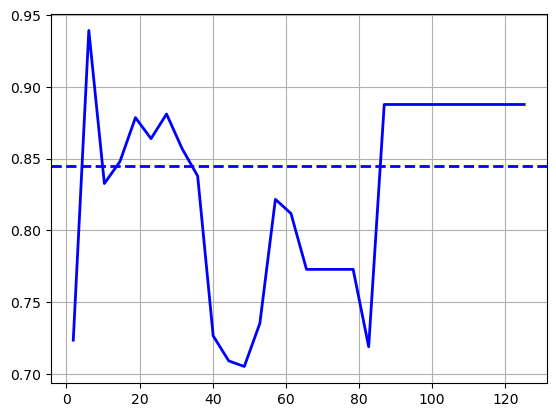

In [68]:
mlp_auc, mlp_mean_auc = cumulative_dynamic_auc(
    y_tr, y_t, mlp_risk_scores, times
)

print("Average MLP: ", mlp_mean_auc)
plt.plot(times, mlp_auc, "b-",label="DeepSurv", linewidth=2)
plt.axhline(mlp_mean_auc, linestyle="--", color="b",linewidth=2)
plt.grid(True)

## <br><br> Evaluating Survival Models

### Time dependent AUC

Average SSVM:  0.8762606271555421
Average CPH:  0.8796277693243102
Average RSF:  0.8561145035973011
Average ETS:  0.8370557047331156
Average GB:  0.854220665448978


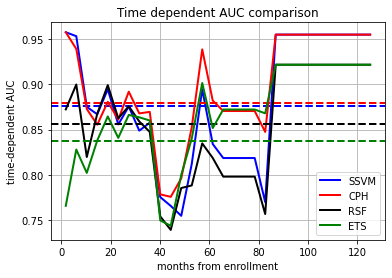

In [128]:
fks_risk_scores=fks.predict(X_t)
fks_auc, fks_mean_auc = cumulative_dynamic_auc(
    y_tr, y_t, fks_risk_scores, times
)

cox_risk_scores=cox.predict(X_t)
cox_auc, cox_mean_auc = cumulative_dynamic_auc(
    y_tr, y_t, cox_risk_scores, times
)

et_risk_scores=et.predict(X_t)
et_auc, et_mean_auc = cumulative_dynamic_auc(
    y_tr, y_t, et_risk_scores, times
)

rsf_risk_scores=rsf.predict(X_t)
rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(
    y_tr, y_t, rsf_risk_scores, times
)


plt.plot(times, fks_auc, "b-",label="SSVM", linewidth=2)
plt.axhline(fks_mean_auc, linestyle="--", color="b",linewidth=2)
plt.plot(times, cox_auc, "r-",label="CPH", linewidth=2)
plt.axhline(cox_mean_auc, linestyle="--", color="r",linewidth=2)
plt.plot(times, rsf_auc, "k-",label="RSF", linewidth=2)
plt.axhline(rsf_mean_auc, linestyle="--", color="k",linewidth=2)
plt.plot(times, et_auc, "g-",label="ETS", linewidth=2)
plt.axhline(et_mean_auc, linestyle="--", color="g",linewidth=2)

plt.xlabel("months from enrollment")
plt.ylabel("time-dependent AUC")
plt.title("Time dependent AUC comparison")
plt.legend(loc="best")
plt.grid(True)

print("Average SSVM: ",fks_mean_auc)
print("Average CPH: ",cox_mean_auc)
print("Average RSF: ",rsf_mean_auc)
print("Average ETS: ",et_mean_auc)

gb_risk_scores=gb.predict(X_t)
gb_auc, gb_mean_auc = cumulative_dynamic_auc(
    y_tr, y_t, gb_risk_scores, times
)

print("Average GB: ",gb_mean_auc)

plt.savefig("DynamicAUC.png", format='png')

### <br><br>  Estimation of Survival Functions

In [62]:
# KAPLAN MEIER ESTIMATION FOR SURVIVAL CURVE 
t_km, surv_km = kaplan_meier_estimator(y_tr['StatusOS'],y_tr['OSGeneraleMesi'])

In [63]:
preds_cox_func = [[fn(t) for t in cox.event_times_] for fn in survs_cox]
t=cox.event_times_

In [111]:
surv=pd.DataFrame(preds_cox_func)
mean_surv=surv.mean()

# PAZIENTI SCELTI DEVE ESSERE MORTI!!

surv['OS']=y_t['OSGeneraleMesi']
surv['Event']=y_t['StatusOS']
surv

,0,1,2,3,4,5,6,7,8,9,...,367,368,369,370,371,372,373,374,OS,Event
0,0.999636,0.999268,0.998895,0.998519,0.998141,0.997763,0.997377,0.996987,0.996596,0.995808,...,1.835519e-01,1.835519e-01,1.530317e-01,1.530317e-01,1.530317e-01,1.530317e-01,7.289498e-02,4.497137e-03,60.933333,False
1,0.994920,0.989804,0.984646,0.979467,0.974300,0.969142,0.963911,0.958651,0.953401,0.942906,...,4.980356e-11,4.980356e-11,3.909073e-12,3.909073e-12,3.909073e-12,3.909073e-12,1.215985e-16,1.431807e-33,5.600000,False
2,0.998181,0.996343,0.994483,0.992610,0.990734,0.988856,0.986944,0.985015,0.983083,0.979200,...,2.071619e-04,2.071619e-04,8.339813e-05,8.339813e-05,8.339813e-05,8.339813e-05,2.040094e-06,1.806176e-12,14.066667,True
3,0.999391,0.998775,0.998152,0.997523,0.996892,0.996259,0.995615,0.994964,0.994311,0.992996,...,5.863392e-02,5.863392e-02,4.325206e-02,4.325206e-02,4.325206e-02,4.325206e-02,1.250571e-02,1.182988e-04,52.633333,True
4,0.989257,0.978504,0.967721,0.956960,0.946286,0.935695,0.925017,0.914345,0.903761,0.882794,...,1.421541e-22,1.421541e-22,6.444376e-25,6.444376e-25,6.444376e-25,6.444376e-25,1.785072e-34,2.255049e-70,2.500000,True
5,0.992635,0.985237,0.977794,0.970340,0.962919,0.955530,0.948053,0.940554,0.933089,0.918219,...,1.116260e-15,1.116260e-15,2.778574e-17,2.778574e-17,2.778574e-17,2.778574e-17,7.992068e-24,2.156520e-48,1.866667,True
6,0.999518,0.999031,0.998538,0.998040,0.997540,0.997040,0.996529,0.996014,0.995497,0.994455,...,1.060480e-01,1.060480e-01,8.336182e-02,8.336182e-02,8.336182e-02,8.336182e-02,3.123584e-02,7.823456e-04,37.733333,True
7,0.999113,0.998215,0.997307,0.996390,0.995472,0.994552,0.993614,0.992667,0.991717,0.989806,...,1.600549e-02,1.600549e-02,1.027162e-02,1.027162e-02,1.027162e-02,1.027162e-02,1.682904e-03,1.885327e-06,8.100000,True
8,0.998123,0.996228,0.994310,0.992379,0.990445,0.988508,0.986537,0.984548,0.982557,0.978554,...,1.587374e-04,1.587374e-04,6.210433e-05,6.210433e-05,6.210433e-05,6.210433e-05,1.352169e-06,7.729319e-13,12.600000,True
9,0.999780,0.999558,0.999332,0.999105,0.998876,0.998648,0.998414,0.998178,0.997942,0.997465,...,3.590622e-01,3.590622e-01,3.217008e-01,3.217008e-01,3.217008e-01,3.217008e-01,2.055190e-01,3.818781e-02,37.200000,True


In [135]:
surv_low=surv['OS']<=5
surv_low=surv[surv_low]
surv_low
# I choose patient 28 (OS=3.1)

,0,1,2,3,4,5,6,7,8,9,...,367,368,369,370,371,372,373,374,OS,Event
4,0.989257,0.978504,0.967721,0.956960,0.946286,0.935695,0.925017,0.914345,0.903761,0.882794,...,1.421541e-22,1.421541e-22,6.444376e-25,6.444376e-25,6.444376e-25,6.444376e-25,1.785072e-34,2.255049e-70,2.500000,True
5,0.992635,0.985237,0.977794,0.970340,0.962919,0.955530,0.948053,0.940554,0.933089,0.918219,...,1.116260e-15,1.116260e-15,2.778574e-17,2.778574e-17,2.778574e-17,2.778574e-17,7.992068e-24,2.156520e-48,1.866667,True
28,0.980356,0.960869,0.941509,0.922367,0.903556,0.885067,0.866602,0.848326,0.830376,0.795333,...,7.389148e-41,7.389148e-41,3.661446e-45,3.661446e-45,3.661446e-45,3.661446e-45,1.017052e-62,1.161569e-128,3.100000,True
29,0.994361,0.988687,0.982968,0.977229,0.971507,0.965798,0.960012,0.954197,0.948398,0.936814,...,3.641621e-12,3.641621e-12,2.158996e-13,2.158996e-13,2.158996e-13,2.158996e-13,2.138724e-18,3.424034e-37,3.100000,True
33,0.996604,0.993179,0.989719,0.986240,0.982762,0.979284,0.975751,0.972191,0.968633,0.961498,...,1.316036e-07,1.316036e-07,2.405269e-08,2.405269e-08,2.405269e-08,2.405269e-08,2.349880e-11,1.161196e-22,4.966667,True
47,0.996186,0.992340,0.988457,0.984554,0.980654,0.976756,0.972798,0.968812,0.964829,0.956849,...,1.860923e-08,1.860923e-08,2.757359e-09,2.757359e-09,2.757359e-09,2.757359e-09,1.144793e-12,2.273307e-25,2.000000,True


In [117]:
# SURVIVAL CURVE FOR PATIENT WITH HIGH OS
surv_high=surv['OS']>=50
surv_high=surv[surv_high]
surv_high
# I choose patient 38 (OS=59.8)

,0,1,2,3,4,5,6,7,8,9,...,367,368,369,370,371,372,373,374,OS,Event
0,0.999636,0.999268,0.998895,0.998519,0.998141,0.997763,0.997377,0.996987,0.996596,0.995808,...,1.835519e-01,1.835519e-01,1.530317e-01,1.530317e-01,1.530317e-01,1.530317e-01,7.289498e-02,4.497137e-03,60.933333,False
3,0.999391,0.998775,0.998152,0.997523,0.996892,0.996259,0.995615,0.994964,0.994311,0.992996,...,5.863392e-02,5.863392e-02,4.325206e-02,4.325206e-02,4.325206e-02,4.325206e-02,1.250571e-02,1.182988e-04,52.633333,True
12,0.996439,0.992848,0.989222,0.985575,0.981930,0.978287,0.974585,0.970857,0.967131,0.959662,...,6.085214e-08,6.085214e-08,1.023851e-08,1.023851e-08,1.023851e-08,1.023851e-08,7.137891e-12,9.930810e-24,50.966667,False
18,0.999769,0.999535,0.999298,0.999059,0.998819,0.998579,0.998333,0.998086,0.997837,0.997336,...,3.407752e-01,3.407752e-01,3.036095e-01,3.036095e-01,3.036095e-01,3.036095e-01,1.895762e-01,3.232616e-02,80.966667,False
22,0.994887,0.989740,0.984549,0.979337,0.974138,0.968948,0.963684,0.958392,0.953111,0.942552,...,4.279583e-11,4.279583e-11,3.304837e-12,3.304837e-12,3.304837e-12,3.304837e-12,9.620402e-17,8.829429e-34,54.600000,False
23,0.999312,0.998616,0.997912,0.997201,0.996489,0.995774,0.995046,0.994311,0.993574,0.992089,...,4.055709e-02,4.055709e-02,2.875759e-02,2.875759e-02,2.875759e-02,2.875759e-02,7.076569e-03,3.653041e-05,85.000000,True
25,0.999815,0.999628,0.999438,0.999246,0.999054,0.998861,0.998665,0.998466,0.998267,0.997866,...,4.222116e-01,4.222116e-01,3.849111e-01,3.849111e-01,3.849111e-01,3.849111e-01,2.639617e-01,6.400698e-02,54.000000,False
31,0.999815,0.999627,0.999437,0.999245,0.999053,0.998860,0.998663,0.998464,0.998265,0.997862,...,4.216732e-01,4.216732e-01,3.843675e-01,3.843675e-01,3.843675e-01,3.843675e-01,2.634418e-01,6.374710e-02,125.133333,True
38,0.999875,0.999748,0.999620,0.999490,0.999360,0.999230,0.999097,0.998962,0.998827,0.998556,...,5.580747e-01,5.580747e-01,5.242275e-01,5.242275e-01,5.242275e-01,5.242275e-01,4.061675e-01,1.557687e-01,59.800000,True
40,0.999755,0.999507,0.999256,0.999002,0.998748,0.998493,0.998233,0.997971,0.997707,0.997176,...,3.194287e-01,3.194287e-01,2.826231e-01,2.826231e-01,2.826231e-01,2.826231e-01,1.715480e-01,2.630227e-02,62.266667,False


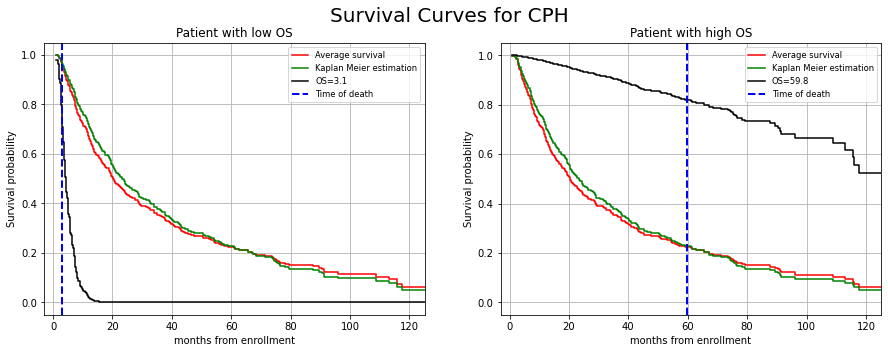

In [137]:
#for pred in preds_cox_func:
#    plt.step(t, pred, where="post", color="k")

plt.figure(figsize=(15,5))


plt.subplot(1,2,1)
plt.step(t,mean_surv, where="post", color="r", label="Average survival")
plt.step(t_km, surv_km, where="post", color="g", label="Kaplan Meier estimation")
plt.step(t, surv.iloc[28,:-2], where="post", color="k", label="OS=3.1")
plt.axvline(surv.loc[28,'OS'], linestyle="--", color="b",linewidth=2, label="Time of death")
plt.legend(loc="best", fontsize='small')
plt.title("Patient with low OS")
plt.xlabel("months from enrollment")
plt.ylabel("Survival probability")
plt.xlim(left=-3,right=max(y_t['OSGeneraleMesi']))
plt.grid(True)

plt.subplot(1,2,2)
plt.step(t,mean_surv, where="post", color="r", label="Average survival")
plt.step(t_km, surv_km, where="post", color="g", label="Kaplan Meier estimation")
plt.step(t, surv.iloc[38,:-2], where="post", color="k", label="OS=59.8")
plt.axvline(surv.loc[38,'OS'], linestyle="--", color="b",linewidth=2, label="Time of death")
plt.legend(loc="best", fontsize='small')
plt.title("Patient with high OS")
plt.xlabel("months from enrollment")
plt.ylabel("Survival probability")
plt.xlim(left=-3,right=max(y_t['OSGeneraleMesi']))
plt.grid(True)

plt.suptitle("Survival Curves for CPH",fontsize=20)

plt.savefig("Survival curves.png", format='png')
plt.show()


In [276]:
cph_results=pd.DataFrame(gcv.cv_results_)
#cph_results=cph_results.loc[:,['params','mean_test_score','std_test_score']]
cph_results
                        

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.065191,0.006299,0.001564,0.004692,5,{'n_iter': 5},0.733333,0.755784,0.741886,0.755008,...,0.766894,0.770772,0.766556,0.767023,0.767488,0.773618,0.763271,0.76531,0.768069,0.002880
1,0.089758,0.010101,0.000667,0.001340,10,{'n_iter': 10},0.733333,0.755784,0.741886,0.755008,...,0.766894,0.770720,0.766487,0.767023,0.767506,0.773618,0.763289,0.76531,0.768059,0.002875
2,0.089028,0.015560,0.003130,0.006259,15,{'n_iter': 15},0.733333,0.755784,0.741886,0.755008,...,0.766894,0.770720,0.766487,0.767023,0.767506,0.773618,0.763289,0.76531,0.768059,0.002875
3,0.085925,0.010476,0.003125,0.006249,20,{'n_iter': 20},0.733333,0.755784,0.741886,0.755008,...,0.766894,0.770720,0.766487,0.767023,0.767506,0.773618,0.763289,0.76531,0.768059,0.002875
4,0.084384,0.012491,0.003116,0.006232,50,{'n_iter': 50},0.733333,0.755784,0.741886,0.755008,...,0.766894,0.770720,0.766487,0.767023,0.767506,0.773618,0.763289,0.76531,0.768059,0.002875
5,0.082804,0.009998,0.001557,0.004672,100,{'n_iter': 100},0.733333,0.755784,0.741886,0.755008,...,0.766894,0.770720,0.766487,0.767023,0.767506,0.773618,0.763289,0.76531,0.768059,0.002875
